In [3]:
!pip install torch torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.9 MB/s eta 0:00:00


In [4]:
!pip install torch torch-geometric scikit-learn matplotlib


In [25]:
#Applying the ANN Model
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# 1. Load Data from CSV
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# 2. Prepare Dataset with Scaled Features and Target, with Log Transformation on Target
def prepare_data(df, feature_scaler=None, target_scaler=None, fit_scalers=False):
    # Extract features (Latitude, Longitude) and apply log transformation to the target (population)
    features = df[['Latitude', 'Longitude']].values
    target = np.log1p(df['population'].values.reshape(-1, 1))  # log(1 + x) to reduce skew

    # Fit and transform features if scaler is provided and fitting is required
    if feature_scaler and fit_scalers:
        features = feature_scaler.fit_transform(features)
    elif feature_scaler:
        features = feature_scaler.transform(features)

    if target_scaler and fit_scalers:
        target = target_scaler.fit_transform(target)
    elif target_scaler:
        target = target_scaler.transform(target)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float)
    target = torch.tensor(target, dtype=torch.float)
    return features, target, feature_scaler, target_scaler

# 3. Updated ANN Model Definition with Extra Layers
class ANNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc4 = torch.nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = torch.nn.Dropout(p=0.3)  # Dropout layer for regularization

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x

# 4. Train and Test Data Preparation
data = load_data('/content/updated_data.csv')

# Split the data into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# Standardize the features and normalize the target with log transformation
feature_scaler = StandardScaler()
target_scaler = MinMaxScaler()

train_features, train_target, feature_scaler, target_scaler = prepare_data(
    train_df, feature_scaler, target_scaler, fit_scalers=True
)
test_features, test_target, _, _ = prepare_data(test_df, feature_scaler, target_scaler)

# Create DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(train_features, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 5. Training the ANN Model
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch_features, batch_target in loader:
        optimizer.zero_grad()
        out = model(batch_features)
        loss = criterion(out.squeeze(), batch_target.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 6. Evaluation Function with Inverse Transform
def evaluate(model, features, target, target_scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(features).squeeze().unsqueeze(1)

        # Inverse transform to compare in original scale
        predictions = target_scaler.inverse_transform(predictions.numpy())
        target = target_scaler.inverse_transform(target.numpy())

        mse = mean_squared_error(target, predictions)
        return mse

# Model parameters
input_dim = 2  # Latitude and Longitude as input
hidden_dim = 64  # Increased hidden dimension
output_dim = 1  # Predicting population

# Initialize model, optimizer, and loss function
model = ANNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)  # Reduced learning rate
criterion = torch.nn.MSELoss()

# Training loop with increased epochs
epochs = 300
for epoch in range(epochs):
    loss = train(model, train_loader, optimizer, criterion)
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Evaluation on the test dataset
test_mse = evaluate(model, test_features, test_target, target_scaler)
print(f'Test Mean Squared Error: {test_mse}')


Epoch 0, Loss: 0.5561629352159798
Epoch 20, Loss: 0.025402951403521
Epoch 40, Loss: 0.022561064222827554
Epoch 60, Loss: 0.022079517075326294
Epoch 80, Loss: 0.02204660404822789
Epoch 100, Loss: 0.021896999882301316
Epoch 120, Loss: 0.021726582053815946
Epoch 140, Loss: 0.021228298370260745
Epoch 160, Loss: 0.0213869426806923
Epoch 180, Loss: 0.021088741734274663
Epoch 200, Loss: 0.021216236957116053
Epoch 220, Loss: 0.02128211631497834
Epoch 240, Loss: 0.021152605608222075
Epoch 260, Loss: 0.020716138489660807
Epoch 280, Loss: 0.020945117576047778
Test Mean Squared Error: 3.0403692722320557


In [26]:
# #Appyling the GNN Model
# import torch
# import torch.nn.functional as F
# import pandas as pd
# from torch_geometric.data import Data
# from torch_geometric.nn import GCNConv
# from sklearn.metrics import mean_squared_error
# import numpy as np
# from scipy.spatial import distance_matrix

# # 1. Load Data from CSV
# def load_data(file_path):
#     df = pd.read_csv(file_path)
#     return df

# # 2. Create Graph Data
# def create_graph(df, distance_threshold):
#     # Node features: Latitude, Longitude, and Population
#     node_features = torch.tensor(df[['Latitude', 'Longitude', 'population']].values, dtype=torch.float)

#     # Create edge index based on proximity (using a distance matrix)
#     coords = df[['Latitude', 'Longitude']].values
#     dist_matrix = distance_matrix(coords, coords)

#     # Define edges where the distance between nodes is less than the threshold
#     edge_index = np.array(np.where(dist_matrix < distance_threshold))
#     edge_index = torch.tensor(edge_index, dtype=torch.long)

#     # Create the graph data structure
#     graph_data = Data(x=node_features, edge_index=edge_index)
#     return graph_data

# # 3. GNN Model Definition
# class GNNModel(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(GNNModel, self).__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, out_channels)

#     def forward(self, x, edge_index):
#         # First GCN Layer
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)

#         # Second GCN Layer
#         x = self.conv2(x, edge_index)

#         return x

# # 4. Train and Test Split (we assume you have separate CSVs for train and test)
# train_data = load_data('/content/updated_data_train.csv')
# test_data = load_data('/content/updated_data.csv')

# # Define a distance threshold for edge creation (e.g., 0.1 degree distance)
# distance_threshold = 0.1

# # Create graph structures
# train_graph = create_graph(train_data, distance_threshold)
# test_graph = create_graph(test_data, distance_threshold)

# # 5. Training the GNN Model
# def train(model, data, optimizer, criterion):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data.x, data.edge_index)

#     # Using population as the target
#     target = data.x[:, 2]  # Population field is the target

#     # Loss function (MSE for regression)
#     loss = criterion(out[:, 2], target)
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# # 6. Evaluation Function
# def evaluate(model, data):
#     model.eval()
#     with torch.no_grad():
#         out = model(data.x, data.edge_index)
#         target = data.x[:, 2]  # Population field
#         pred = out[:, 2]  # Predicted population
#         mse = mean_squared_error(target.numpy(), pred.numpy())
#         return mse

# input_features = 3  # Latitude, Longitude, Population
# hidden_features = 16
# output_features = 3  # Output the same features

# # Initialize model, optimizer, and loss function
# model = GNNModel(in_channels=input_features, hidden_channels=hidden_features, out_channels=output_features)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# # Training loop
# epochs = 100
# for epoch in range(epochs):
#     loss = train(model, train_graph, optimizer, criterion)
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss}')

# # Evaluation on the test dataset
# mse = evaluate(model, test_graph)
# print(f'Test Mean Squared Error: {mse}')




Epoch 0, Loss: 2533702912.0
Epoch 10, Loss: 1800546560.0
Epoch 20, Loss: 1353761664.0
Epoch 30, Loss: 1325373696.0
Epoch 40, Loss: 1312950272.0
Epoch 50, Loss: 1301336192.0
Epoch 60, Loss: 1302399360.0
Epoch 70, Loss: 1300101888.0
Epoch 80, Loss: 1300386816.0
Epoch 90, Loss: 1300065152.0
Test Mean Squared Error: 911484864.0


<ipython-input-30-a9b2e462cf8f>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.0604019  0.01849852 0.17248462 ... 0.86889643 0.03592305 0.03592305]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_coords.loc[:, ['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Number of edges: 35
Epoch 0, Loss: 0.3010880649089813
Epoch 10, Loss: 0.030481835827231407
Epoch 20, Loss: 0.010572788305580616
Epoch 30, Loss: 0.004457429517060518
Epoch 40, Loss: 0.0022274150978773832
Epoch 50, Loss: 0.0008447534055449069
Epoch 60, Loss: 0.0004203303251415491
Epoch 70, Loss: 0.00021145466598682106
Epoch 80, Loss: 0.00017543972353450954
Epoch 90, Loss: 0.0001468348054913804
Epoch 100, Loss: 0.00012945692287757993
Epoch 110, Loss: 0.00011759615881601349
Epoch 120, Loss: 0.00010918792395386845
Epoch 130, Loss: 0.00010208111780229956
Epoch 140, Loss: 9.608177788322791e-05
Epoch 150, Loss: 9.091198444366455e-05
Epoch 160, Loss: 8.631148375570774e-05
Epoch 170, Loss: 8.232564141508192e-05
Epoch 180, Loss: 7.888101390562952e-05
Epoch 190, Loss: 7.591844041598961e-05
Epoch 200, Loss: 7.333229586947709e-05
Epoch 210, Loss: 7.104883115971461e-05
Epoch 220, Loss: 6.902265886310488e-05
Epoch 230, Loss: 6.721990939695388e-05
Epoch 240, Loss: 6.559335452038795e-05
Epoch 250, Loss:

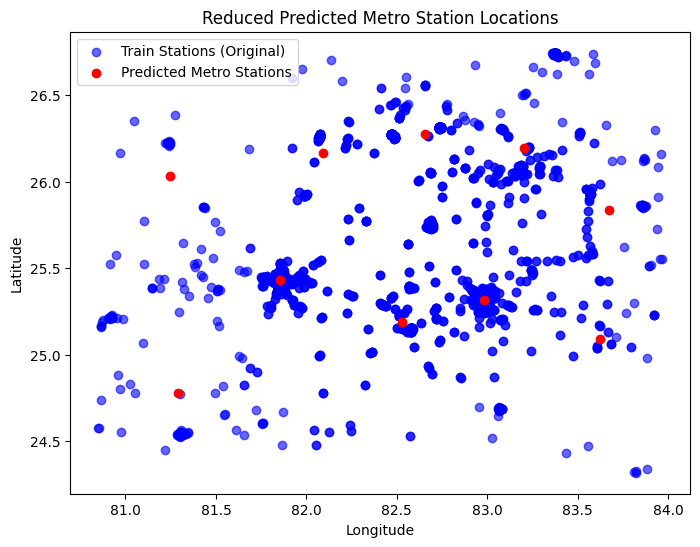

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords.loc[:, ['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
# Adjust `n_neighbors` to control connectivity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])

# Set a population difference threshold to further limit edges
population_threshold = 0.1
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] - train_coords['population'].iloc[neighbors[j]])

        # Add the edge only if the population difference is above the threshold
        if population_diff > population_threshold:
            G.add_edge(i, neighbors[j], weight=population_diff)

# Check that the graph has edges
print(f'Number of edges: {len(G.edges)}')

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Check if there are any edges
if len(edge_index) == 0:
    raise ValueError("No edges were created in the graph. Check the edge creation logic.")

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)  # Input: 3 features (Lat, Long, Population)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 2)  # Output: 2 features (Predicted Lat, Long)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        x = torch.relu(x)
        x = self.conv3(x, edge_index, edge_weight=edge_weight)
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    target = data.x[:, :2]  # Target is Latitude and Longitude (first two features)
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Apply KMeans clustering to reduce the number of predicted metro station locations
num_clusters = 10  # Adjust based on the desired number of final metro stations
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(predicted_positions)
reduced_predicted_positions = kmeans.cluster_centers_

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
reduced_predicted_positions[:, 0] = np.clip(reduced_predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and reduced predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(reduced_predicted_positions[:, 1], reduced_predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Reduced Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-7-c1796243438e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.4010353088378906
Epoch 10, Loss: 0.03832724317908287
Epoch 20, Loss: 0.02368198335170746
Epoch 30, Loss: 0.018160590901970863
Epoch 40, Loss: 0.014364713802933693
Epoch 50, Loss: 0.011821646243333817
Epoch 60, Loss: 0.009492789395153522
Epoch 70, Loss: 0.007009115070104599
Epoch 80, Loss: 0.005584727041423321
Epoch 90, Loss: 0.004723482299596071
Epoch 100, Loss: 0.0037203424144536257
Epoch 110, Loss: 0.00327545078471303
Epoch 120, Loss: 0.0029480408411473036
Epoch 130, Loss: 0.00266855675727129
Epoch 140, Loss: 0.002351790899410844
Epoch 150, Loss: 0.0021533530671149492
Epoch 160, Loss: 0.001909883925691247
Epoch 170, Loss: 0.0017357486067339778
Epoch 180, Loss: 0.0018768080044537783
Epoch 190, Loss: 0.0014802232617512345
Epoch 200, Loss: 0.0014538218965753913
Epoch 210, Loss: 0.0017161983996629715
Epoch 220, Loss: 0.0012399095576256514
Epoch 230, Loss: 0.0013047712855041027
Epoch 240, Loss: 0.001228372915647924
Epoch 250, Loss: 0.001508193789049983
Epoch 260, Loss: 0.

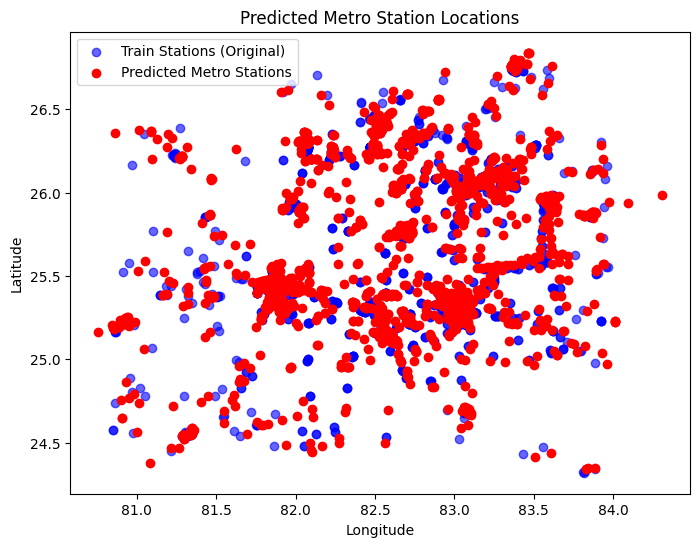

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model for regression (output latitude and longitude)
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 32)
        self.conv5 = GCNConv(32, 2)  # Output 2 values for latitude and longitude

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = self.conv5(x, edge_index, edge_weight=edge_weight)  # Output latitude and longitude
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare target data (latitude and longitude) for regression
target = torch.tensor(train_coords[['Latitude', 'Longitude']].values, dtype=torch.float)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # MSE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Inverse transform (convert back to original scale) the predictions
model.eval()
predicted_positions = model(data).detach().numpy()

# Add a third column (population) to the predicted positions before inverse transform
# We can fill the population column with zeros for now as it's not used in predictions
predicted_positions_with_population = np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))

# Inverse transform the predictions using the same scaler (for Lat, Long, Population)
predicted_positions = scaler.inverse_transform(predicted_positions_with_population)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Plot the original train data and predicted station locations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()



<ipython-input-10-6af2ee585009>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 2.3276994228363037
Epoch 10, Loss: 2.0403056144714355
Epoch 20, Loss: 1.468717336654663
Epoch 30, Loss: 1.189436912536621
Epoch 40, Loss: 1.0041396617889404
Epoch 50, Loss: 0.8568384647369385
Epoch 60, Loss: 0.7161893248558044
Epoch 70, Loss: 0.512292206287384
Epoch 80, Loss: 0.32487747073173523
Epoch 90, Loss: 0.2005908489227295
Epoch 100, Loss: 0.13978944718837738
Epoch 110, Loss: 0.10713811218738556
Epoch 120, Loss: 0.09088882803916931
Epoch 130, Loss: 0.0766548290848732
Epoch 140, Loss: 0.06898796558380127
Epoch 150, Loss: 0.06220868229866028
Epoch 160, Loss: 0.05645933374762535
Epoch 170, Loss: 0.052367132157087326
Epoch 180, Loss: 0.048564936965703964
Epoch 190, Loss: 0.04596930742263794
Epoch 200, Loss: 0.04332578182220459
Epoch 210, Loss: 0.040860865265131
Epoch 220, Loss: 0.03837137669324875
Epoch 230, Loss: 0.036417264491319656
Epoch 240, Loss: 0.034643325954675674
Epoch 250, Loss: 0.033343855291604996
Epoch 260, Loss: 0.03141631558537483
Epoch 270, Loss: 0.029

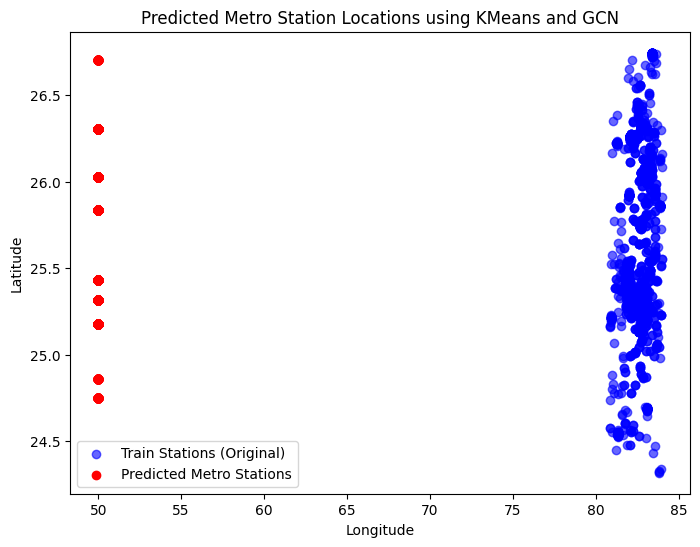

In [10]:
#Applying KNN on the models
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Apply KMeans clustering to find the cluster centers (Metro stations)
n_clusters = 10  # Set the number of clusters (stations)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(train_coords[['Latitude', 'Longitude']])

# Add cluster centers as the target locations for training
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.predict(train_coords[['Latitude', 'Longitude']])

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model to predict the cluster labels
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 16)  # Reduced complexity
        self.conv4 = GCNConv(16, n_clusters)  # Output: n_clusters (number of metro stations)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = self.conv4(x, edge_index, edge_weight=edge_weight)  # No activation here
        return x

# Initialize the model, loss function, and optimizer
model = GCN()
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss as we're predicting cluster labels
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    target = torch.tensor(cluster_labels, dtype=torch.long)  # Cluster labels as the target
    loss = criterion(out, target)  # Cross-entropy loss for classifying nodes into clusters
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# After training, predict the cluster labels for each node
model.eval()
predicted_labels = model(data).detach().numpy()

# Convert predicted cluster labels to corresponding cluster centers (latitude, longitude)
predicted_positions = cluster_centers[np.argmax(predicted_labels, axis=1)]

# Prepare the predicted positions with a dummy population column
# Assuming that population is not necessary for prediction; we set it to 0 (or any constant value)
dummy_population = np.zeros(predicted_positions.shape[0]).reshape(-1, 1)

# Combine the predicted positions with the dummy population (so it's a 3D feature array)
predicted_positions_with_population = np.hstack([predicted_positions, dummy_population])

# Inverse transform the predicted positions (Lat, Long, Population) using the scaler
predicted_positions_with_population = scaler.inverse_transform(predicted_positions_with_population)

# Extract only the latitude and longitude (ignore the dummy population column)
predicted_positions = predicted_positions_with_population[:, :2]

# Clip the latitude and longitude to valid ranges
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range
predicted_positions[:, 1] = np.clip(predicted_positions[:, 1], 0, 50)  # Longitude range

# Plot the original train data and predicted metro stations (cluster centers)
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations using KMeans and GCN')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-11-6763777f67f6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6936489343643188
Epoch 10, Loss: 0.6924388408660889
Epoch 20, Loss: 0.692060649394989
Epoch 30, Loss: 0.691630482673645
Epoch 40, Loss: 0.691678524017334
Epoch 50, Loss: 0.6907490491867065
Epoch 60, Loss: 0.6905573606491089
Epoch 70, Loss: 0.6900712251663208
Epoch 80, Loss: 0.6893560886383057
Epoch 90, Loss: 0.6887096762657166
Epoch 100, Loss: 0.6888459920883179
Epoch 110, Loss: 0.6870941519737244
Epoch 120, Loss: 0.6865983605384827
Epoch 130, Loss: 0.6888167858123779
Epoch 140, Loss: 0.6882140636444092
Epoch 150, Loss: 0.6868875026702881
Epoch 160, Loss: 0.6863611340522766
Epoch 170, Loss: 0.686425507068634
Epoch 180, Loss: 0.6853958368301392
Epoch 190, Loss: 0.6874333024024963
Epoch 200, Loss: 0.6837031841278076
Epoch 210, Loss: 0.6926146149635315
Epoch 220, Loss: 0.6899423003196716
Epoch 230, Loss: 0.6883631348609924
Epoch 240, Loss: 0.6869691610336304
Epoch 250, Loss: 0.6924631595611572
Epoch 260, Loss: 0.6924169659614563
Epoch 270, Loss: 0.6911980509757996
Epoch 2

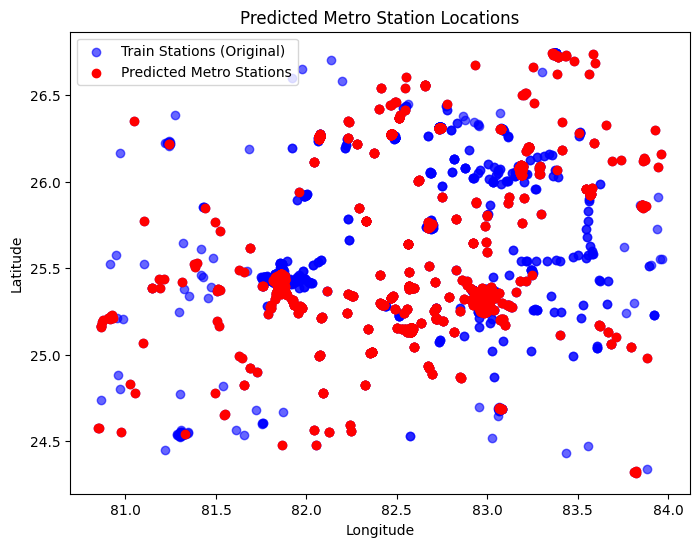

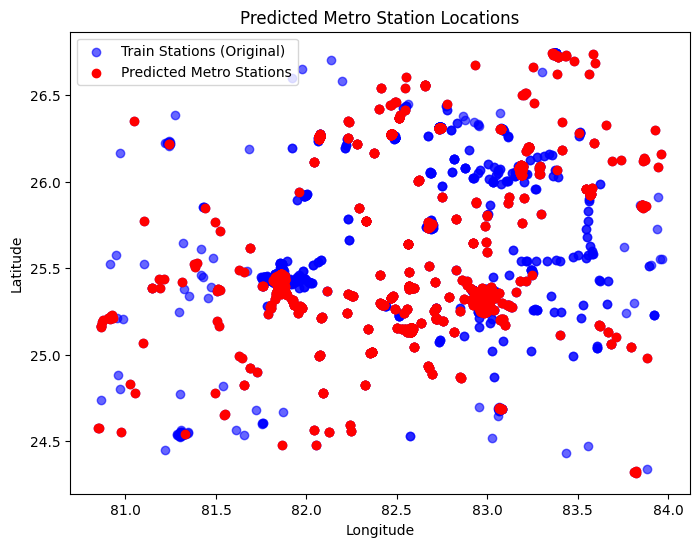

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
# For demonstration, using random binary labels. Replace with actual binary target labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Obtain predictions and convert them to binary classification
# Post-process: Obtain predictions, apply threshold, and convert back to original latitude/longitude scale
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5 to get binary labels

# Add the binary column for metro station prediction
train_data['Predicted_Metro_Station'] = predicted_labels

# Extract only the latitude and longitude for inverse scaling
predicted_coords = np.zeros((predicted_labels.shape[0], 3))
predicted_coords[:, :2] = train_coords[['Latitude', 'Longitude']].values
predicted_coords[:, 2] = predicted_labels  # Place binary predictions for scaling

# Inverse transform only the coordinates (Latitude and Longitude)
predicted_coords = scaler.inverse_transform(predicted_coords)
predicted_positions = predicted_coords[predicted_coords[:, 2] == 1, :2]  # Select predicted metro stations

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-12-19f8c95feb45>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.693152666091919, Accuracy: 50.44%
Epoch 10, Loss: 0.6928648948669434, Accuracy: 50.44%
Epoch 20, Loss: 0.6931192874908447, Accuracy: 50.32%
Epoch 30, Loss: 0.6929421424865723, Accuracy: 50.44%
Epoch 40, Loss: 0.6926625370979309, Accuracy: 51.02%
Epoch 50, Loss: 0.6921555995941162, Accuracy: 51.83%
Epoch 60, Loss: 0.6915318965911865, Accuracy: 51.76%
Epoch 70, Loss: 0.6911098957061768, Accuracy: 52.62%
Epoch 80, Loss: 0.6907898783683777, Accuracy: 52.24%
Epoch 90, Loss: 0.6902732849121094, Accuracy: 52.55%
Epoch 100, Loss: 0.6896712779998779, Accuracy: 53.17%
Epoch 110, Loss: 0.6905103921890259, Accuracy: 53.10%
Epoch 120, Loss: 0.689011812210083, Accuracy: 53.96%
Epoch 130, Loss: 0.6890332102775574, Accuracy: 54.32%
Epoch 140, Loss: 0.6874551177024841, Accuracy: 54.08%
Epoch 150, Loss: 0.6880472898483276, Accuracy: 54.11%
Epoch 160, Loss: 0.6871448755264282, Accuracy: 53.89%
Epoch 170, Loss: 0.6867616772651672, Accuracy: 54.03%
Epoch 180, Loss: 0.6856098771095276, Accu

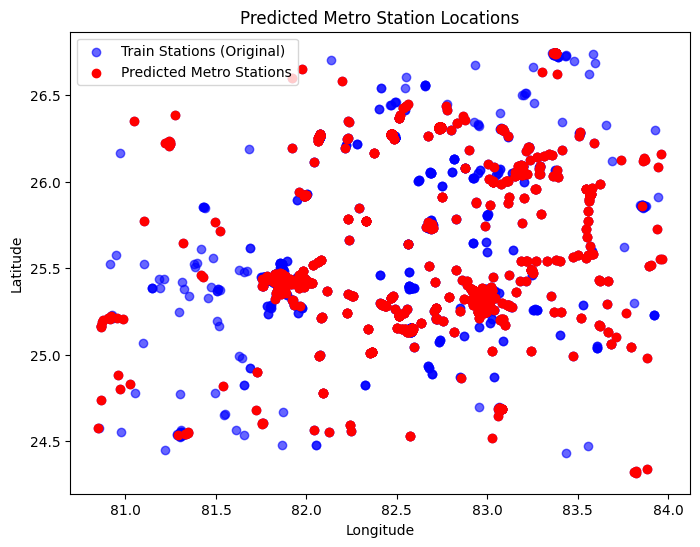

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])
        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
# For demonstration, using random binary labels. Replace with actual binary target labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model with accuracy tracking
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    with torch.no_grad():
        predicted_labels = (out > 0.5).float()  # Convert probabilities to binary (0 or 1)
        correct = (predicted_labels == target).sum().item()
        accuracy = correct / target.size(0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

# Post-process: Obtain predictions, apply threshold, and convert back to original latitude/longitude scale
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5 to get binary labels

# Add the binary column for metro station prediction
train_data['Predicted_Metro_Station'] = predicted_labels

# Extract only the latitude and longitude for inverse scaling
predicted_coords = np.zeros((predicted_labels.shape[0], 3))
predicted_coords[:, :2] = train_coords[['Latitude', 'Longitude']].values
predicted_coords[:, 2] = predicted_labels  # Place binary predictions for scaling

# Inverse transform only the coordinates (Latitude and Longitude)
predicted_coords = scaler.inverse_transform(predicted_coords)
predicted_positions = predicted_coords[predicted_coords[:, 2] == 1, :2]  # Select predicted metro stations

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


          Amenity Type                                             Name  \
0                  bar                                       mohini bar   
1                  bar                                      The Gem Bar   
2                  bar                                OMG Bar & Kitchen   
3                  bar                                         My Love    
4                  bar                                        Sam's bar   
...                ...                                              ...   
1274  place_of_worship  Dargah Hazrat Baba Rangeele Shah Chisthi Nizami   
1275  place_of_worship                         Sindhi Sat Sangat Darbar   
1276       public_bath                                      Deluxe Bath   
1277       public_bath                                      Deluxe Bath   
1278   public_building                                              NIC   

       Latitude  Longitude                               road  \
0     28.633277  77.223876        

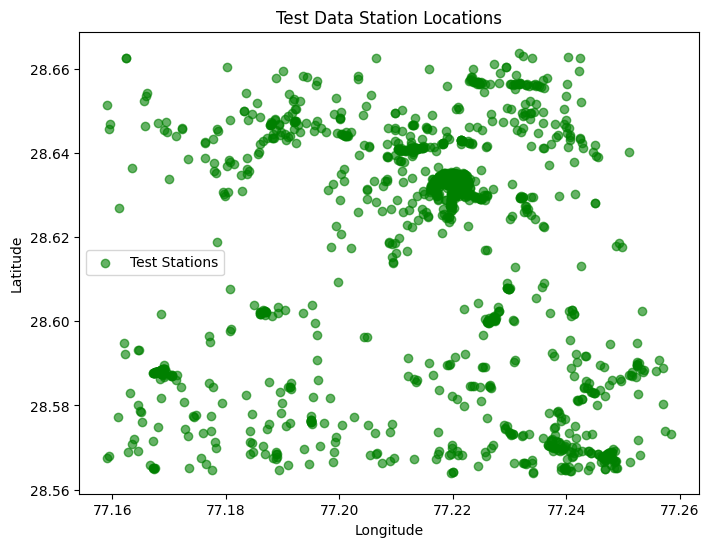

In [13]:
# Load the test data
test_data = pd.read_csv('updated_data.csv')

print(test_data)
# Extract necessary columns (Latitude, Longitude, Population)
test_coords = test_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude and Longitude using MinMaxScaler (use the same scaler from the training data)
# test_coords[['Latitude', 'Longitude']] = scaler.transform(
#     test_coords[['Latitude', 'Longitude']]
# )

# Plot the original test data
plt.figure(figsize=(8, 6))
plt.scatter(test_coords['Longitude'], test_coords['Latitude'], color='green', label='Test Stations', alpha=0.6)
plt.title('Test Data Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


          Amenity Type                                       Name   Latitude  \
0                  bar                                      jyoti  26.070360   
1                  bar                                      Lassi  25.429981   
2                  bar                                 Beer “Bar”  25.308876   
3                  bar                                   Beer Bar  25.309253   
4                  bar                                    Sol Bar  25.338722   
...                ...                                        ...        ...   
4172  place_of_worship                               Shiva Mandir  25.308244   
4173  place_of_worship                             Sita Mata Dham  25.771454   
4174  place_of_worship  Sri Mahavir Ji Mandir Temple Bari Bagahin  25.245697   
4175  place_of_worship                                Shiv Temple  25.638992   
4176  place_of_worship                         Chaura Mata Mandir  25.638231   

      Longitude                       r

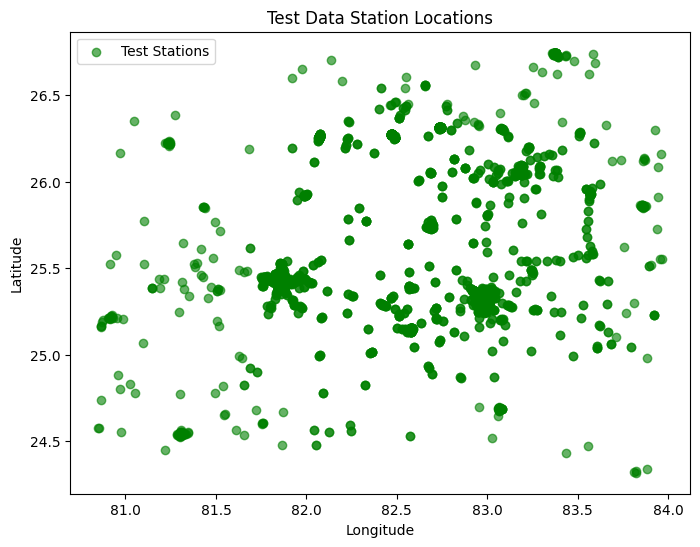

In [14]:
# Load the test data
test_data = pd.read_csv('updated_data_train.csv')

print(test_data)
# Extract necessary columns (Latitude, Longitude, Population)
test_coords = test_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude and Longitude using MinMaxScaler (use the same scaler from the training data)
# test_coords[['Latitude', 'Longitude']] = scaler.transform(
#     test_coords[['Latitude', 'Longitude']]
# )

# Plot the original test data
plt.figure(figsize=(8, 6))
plt.scatter(test_coords['Longitude'], test_coords['Latitude'], color='green', label='Test Stations', alpha=0.6)
plt.title('Test Data Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


<ipython-input-15-3bbba6763fad>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6934947371482849
Epoch 10, Loss: 0.6930490732192993
Epoch 20, Loss: 0.6924664974212646
Epoch 30, Loss: 0.6913546919822693
Epoch 40, Loss: 0.6910998821258545
Epoch 50, Loss: 0.6904789805412292
Epoch 60, Loss: 0.6896823048591614
Epoch 70, Loss: 0.6907392740249634
Epoch 80, Loss: 0.6894263029098511
Epoch 90, Loss: 0.6882234811782837
Epoch 100, Loss: 0.6887291669845581
Epoch 110, Loss: 0.6903831362724304
Epoch 120, Loss: 0.6895064115524292
Epoch 130, Loss: 0.6883801221847534
Epoch 140, Loss: 0.6875907182693481
Epoch 150, Loss: 0.687676727771759
Epoch 160, Loss: 0.6893830895423889
Epoch 170, Loss: 0.6883023381233215
Epoch 180, Loss: 0.6865208148956299
Epoch 190, Loss: 0.6854842305183411
Epoch 200, Loss: 0.690888524055481
Epoch 210, Loss: 0.6882205605506897
Epoch 220, Loss: 0.6870773434638977
Epoch 230, Loss: 0.6855504512786865
Epoch 240, Loss: 0.6883251667022705
Epoch 250, Loss: 0.6879963874816895
Epoch 260, Loss: 0.6866006851196289
Epoch 270, Loss: 0.6879590153694153
Epoch

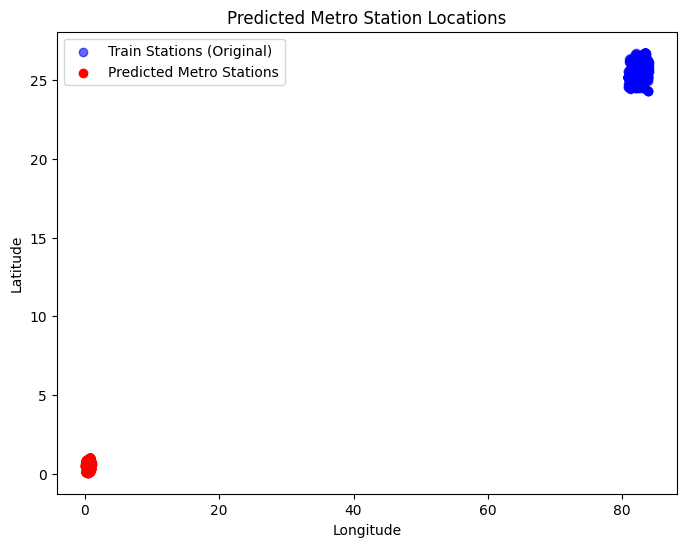

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the train and test data
train_data = pd.read_csv('updated_data_train.csv')
test_data = pd.read_csv('updated_data.csv')

# Extract necessary columns (Latitude, Longitude, Population)
train_coords = train_data[['Latitude', 'Longitude', 'population']]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])

        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Output layer for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Remove single-dimensional entries from the shape

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare target labels (binary: 1 for metro station, 0 for non-station)
# Example: create random binary labels as a placeholder. Replace with actual labels.
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Post-process: Obtain predictions
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Binarize probabilities to get labels (0 or 1)

# Plot the original train data and predicted stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
predicted_positions = train_coords[['Longitude', 'Latitude']].iloc[predicted_labels == 1]
plt.scatter(predicted_positions['Longitude'], predicted_positions['Latitude'], color='red', label='Predicted Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [16]:
import random

# After predicting all the stations:
predicted_positions = model(data).detach().numpy()

# Inverse transform the predictions using the same scaler (for Lat, Long)
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip the latitude values to stay within a valid range (Assume 0 to 50)
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)  # Latitude range

# Step 1: Randomly select 100 stations from the predicted positions
if predicted_positions.shape[0] > 100:
    sampled_positions = random.sample(predicted_positions.tolist(), 100)
    sampled_positions = np.array(sampled_positions)
else:
    sampled_positions = predicted_positions  # If less than 100 predicted, use all

# Step 2: Plot only the selected 100 stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label='Predicted Metro Stations (100)')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume `model`, `scaler`, `data`, and `train_data` are defined and initialized.

# Predict positions
predicted_positions = model(data).detach().numpy()

# Inverse transform predictions for Latitude and Longitude
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip Latitude values to a valid range
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)

# List of different numbers of points to sample for analysis
sample_sizes = [50, 100, 150, 200]  # Example sample sizes

# Loop over each sample size and calculate accuracy
for sample_size in sample_sizes:
    if predicted_positions.shape[0] > sample_size:
        sampled_positions = random.sample(predicted_positions.tolist(), sample_size)
        sampled_positions = np.array(sampled_positions)
    else:
        sampled_positions = predicted_positions  # Use all if fewer than sample size

    # Accuracy Score Calculation (Assuming `true_positions` is defined for comparison)
    # Here, `true_positions` should contain actual Lat and Long values to compare.
    accuracy_score = mean_squared_error(true_positions[:sample_size], sampled_positions) if 'true_positions' in locals() else 'N/A'

    # Plot the selected number of stations
    plt.figure(figsize=(8, 6))
    plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
    plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label=f'Predicted Metro Stations ({sample_size})')
    plt.title(f'Predicted Metro Station Locations (Sample Size: {sample_size})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

    # Print accuracy score
    print(f"Sample Size: {sample_size}, Accuracy Score (MSE): {accuracy_score}")


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume `model`, `scaler`, `data`, `train_data`, and `true_positions` are defined and initialized.

# Predict positions
predicted_positions = model(data).detach().numpy()

# Inverse transform predictions for Latitude and Longitude
predicted_positions = scaler.inverse_transform(
    np.hstack((predicted_positions, np.zeros((predicted_positions.shape[0], 1))))
)[:, :2]  # Only take Lat and Long

# Clip Latitude values to a valid range
predicted_positions[:, 0] = np.clip(predicted_positions[:, 0], 0, 50)

# List of different numbers of points to sample for analysis
sample_sizes = [50, 100, 150, 200]  # Example sample sizes

# Loop over each sample size and calculate accuracy
for sample_size in sample_sizes:
    if predicted_positions.shape[0] > sample_size:
        sampled_indices = random.sample(range(predicted_positions.shape[0]), sample_size)
        sampled_positions = predicted_positions[sampled_indices]
        sampled_true_positions = true_positions[sampled_indices]  # Select corresponding true positions
    else:
        sampled_positions = predicted_positions  # Use all if fewer than sample size
        sampled_true_positions = true_positions  # Use all true positions

    # Calculate accuracy (MSE)
    accuracy_score = mean_squared_error(sampled_true_positions, sampled_positions)

    # Plot the selected number of stations
    plt.figure(figsize=(8, 6))
    plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
    plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label=f'Predicted Metro Stations ({sample_size})')
    plt.title(f'Predicted Metro Station Locations (Sample Size: {sample_size})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

    # Print accuracy score
    print(f"Sample Size: {sample_size}, Accuracy Score (MSE): {accuracy_score}")


In [ ]:
import heapq
import math

# Heuristic function: Euclidean distance between two nodes
def heuristic(node1, node2):
    return math.sqrt((node1[0] - node2[0]) ** 2 + (node1[1] - node2[1]) ** 2)

# A* algorithm to find the path between two nodes
def astar(start, goal, graph):
    open_list = []
    heapq.heappush(open_list, (0, start))

    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0

    f_score = {node: float('inf') for node in graph}
    f_score[start] = heuristic(start, goal)

    while open_list:
        _, current = heapq.heappop(open_list)

        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]  # Return reversed path

        for neighbor in graph[current]:
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_score[neighbor], neighbor))

    return []  # Return an empty path if no path is found

# Build a graph for A* pathfinding from the selected 100 stations
def build_graph(stations):
    graph = {}
    for i, station1 in enumerate(stations):
        graph[tuple(station1)] = []
        for j, station2 in enumerate(stations):
            if i != j:
                graph[tuple(station1)].append(tuple(station2))
    return graph

# After random selection of 100 stations:
if predicted_positions.shape[0] > 100:
    sampled_positions = random.sample(predicted_positions.tolist(), 100)
    sampled_positions = np.array(sampled_positions)
else:
    sampled_positions = predicted_positions  # If less than 100 predicted, use all

# Step 1: Build the graph from the selected 100 stations
graph = build_graph(sampled_positions)

# Step 2: Connect all stations using A* algorithm and store the paths
metro_lines = []
for i in range(len(sampled_positions) - 1):
    start_station = tuple(sampled_positions[i])
    end_station = tuple(sampled_positions[i + 1])
    path = astar(start_station, end_station, graph)
    metro_lines.append(path)

# Step 3: Plot the metro stations and the A* metro lines
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
plt.scatter(sampled_positions[:, 1], sampled_positions[:, 0], color='red', label='Predicted Metro Stations (100)')

# Plotting metro lines
for path in metro_lines:
    if path:  # Ensure the path is valid
        path = np.array(path)
        plt.plot(path[:, 1], path[:, 0], color='green',)

plt.title('Predicted Metro Station Locations and Metro Line (A*)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()
